This notebook shows the model performance of different vectorization approaches (with or without transition state information).

# Load Dependencies

In [28]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score,mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

%matplotlib notebook
random_seed = 2022

# Load Descriptors and Data

In [33]:
physorg_with_different_vect_approach = np.load('./descriptors/physorg_with_different_vect_approach.npz',allow_pickle=True)

## Biaryl, olefin, TDG vectorization with only ground state geometries
b_gs_o_gs_t_gs = physorg_with_different_vect_approach['b_gs_o_gs_t_gs']
b_gs_o_gs_t_gs_name = physorg_with_different_vect_approach['b_gs_o_gs_t_gs_name']

## Besides ground state geometries, TS information is used for biaryl.
b_ts_o_gs_t_gs = physorg_with_different_vect_approach['b_ts_o_gs_t_gs']
b_ts_o_gs_t_gs_name = physorg_with_different_vect_approach['b_ts_o_gs_t_gs_name']

## Besides ground state geometries, TS information is used for olefin.
b_gs_o_ts_t_gs = physorg_with_different_vect_approach['b_gs_o_ts_t_gs']
b_gs_o_ts_t_gs_name = physorg_with_different_vect_approach['b_gs_o_ts_t_gs_name']

## Besides ground state geometries, TS information is used for TDG.
b_gs_o_gs_t_ts = physorg_with_different_vect_approach['b_gs_o_gs_t_ts']
b_gs_o_gs_t_ts_name = physorg_with_different_vect_approach['b_gs_o_gs_t_ts_name']

## Besides ground state geometries, TS information is used for biaryl, olefin and TDG.
biaryl_ts_olefin_ts_tdg_ts = np.load('./descriptors/physorg_desc.npz',allow_pickle=True)
b_ts_o_ts_t_ts = biaryl_ts_olefin_ts_tdg_ts['react_desc']
b_ts_o_ts_t_ts_name = biaryl_ts_olefin_ts_tdg_ts['react_desc_name']

dataset = pd.read_csv('./datasets/dataset.csv',index_col=0)
ddG = dataset['ddG(kcal/mol)'].to_numpy()

'''
The "test_index" is the index of the out-of-sample (OOS) test set, which should be excluded 
during the cross-validation procedure. 

OOS test set: 28 compounds (7 biaryls, 14 olefins and 7 TDGs) have only one associated 
transformation, and these transformations are selected out of the original dataset as 
the out-of-sample (OOS) test set. The details of the selection of OOS test set can be
found in Notebook 4.
'''
test_index = [15, 21, 31, 52, 56, 58, 59, 65, 96, 104, 105, 106, 107, 108, 109,
              110, 111, 112, 113, 114, 115, 120, 121, 122, 123, 124, 125, 126]
train_val_index = list(set(range(len(ddG))) - set(test_index))

# Comparison

In this section, we compare the model performance with or without the transition state encoding for each reaction component. Hyperparameter optimization and feature selection are performed for every vectorization approach.

## Biaryl (GS) Olefin (GS) TDG (GS)

Hyperparameter Optimization

In [50]:
train_val_desc = b_gs_o_gs_t_gs[train_val_index]
train_val_target = ddG[train_val_index]
oos_desc = b_gs_o_gs_t_gs[test_index]
oos_target = ddG[test_index]

paras = {'n_estimators':[100,200,300,400,500,600],'max_depth': [None, 5, 10, 15, 20]}
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
model = ExtraTreesRegressor(n_jobs=-1,random_state=random_seed)
GS = GridSearchCV(model,paras,cv=cv,n_jobs=-1,scoring='r2')
GS.fit(train_val_desc,train_val_target)
best_param = GS.best_params_

Feature Selection

In [51]:
model = ExtraTreesRegressor(max_depth=best_param['max_depth'],n_estimators=best_param['n_estimators'],
                            n_jobs=-1,random_state=random_seed)

selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(train_val_desc,train_val_target)
sel_index = np.where(selector.support_==True)[0]

Cross-Validation

In [52]:
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(train_val_desc):
    train_x,val_x = train_val_desc[:,sel_index][train_idx],train_val_desc[:,sel_index][val_idx]
    train_y,val_y = train_val_target[train_idx],train_val_target[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.2354, R2: 0.9154, Pearson R: 0.9568


<IPython.core.display.Javascript object>


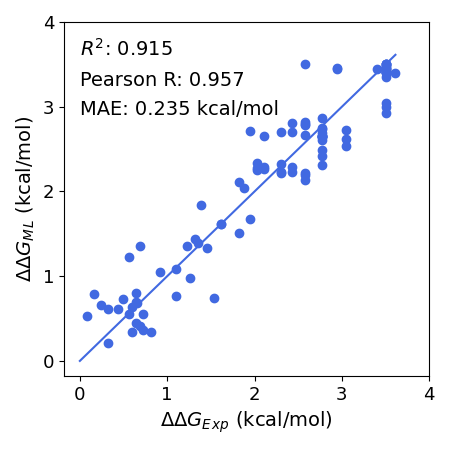

In [53]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='royalblue')

plt.text(0,3.6,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(val_Y,val_P),fontsize=14)

plt.plot([0,ddG.max()],[0,ddG.max()],c='royalblue')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()

OOS Test Set

In [54]:
oos_P = []
feature_importance = []
for _ in range(10):
    model.fit(train_val_desc[:,sel_index],train_val_target)
    oos_p = model.predict(oos_desc[:,sel_index])
    oos_P.append(oos_p)
oos_pred = np.mean(oos_P,axis=0)

r2 = r2_score(oos_target,oos_pred)
pearson_r,_ = pearsonr(oos_target,oos_pred)
mae = mean_absolute_error(oos_target,oos_pred)
print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.4255, R2: 0.7712, Pearson R: 0.8998


<IPython.core.display.Javascript object>


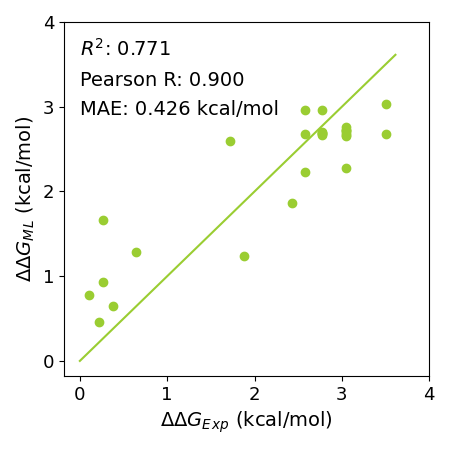

In [55]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(oos_target,oos_pred,c='yellowgreen')
plt.text(0,3.6,'$R^2$: %.3f'%r2_score(oos_target,oos_pred),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(oos_target,oos_pred)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(oos_target,oos_pred),fontsize=14)
plt.plot([0,ddG.max()],[0,ddG.max()],c='yellowgreen')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()

## Biaryl (TS) Olefin (GS) TDG (GS)

Hyperparameter Optimization

In [56]:
train_val_desc = b_ts_o_gs_t_gs[train_val_index]
train_val_target = ddG[train_val_index]
oos_desc = b_ts_o_gs_t_gs[test_index]
oos_target = ddG[test_index]

paras = {'n_estimators':[100,200,300,400,500,600],'max_depth': [None, 5, 10, 15, 20]}
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
model = ExtraTreesRegressor(n_jobs=-1,random_state=random_seed)
GS = GridSearchCV(model,paras,cv=cv,n_jobs=-1,scoring='r2')
GS.fit(train_val_desc,train_val_target)
best_param = GS.best_params_

Feature Selection

In [57]:
model = ExtraTreesRegressor(max_depth=best_param['max_depth'],n_estimators=best_param['n_estimators'],
                            n_jobs=-1,random_state=random_seed)

selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(train_val_desc,train_val_target)
sel_index = np.where(selector.support_==True)[0]

Cross-Validation

In [58]:
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(train_val_desc):
    train_x,val_x = train_val_desc[:,sel_index][train_idx],train_val_desc[:,sel_index][val_idx]
    train_y,val_y = train_val_target[train_idx],train_val_target[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.2331, R2: 0.9130, Pearson R: 0.9555


<IPython.core.display.Javascript object>


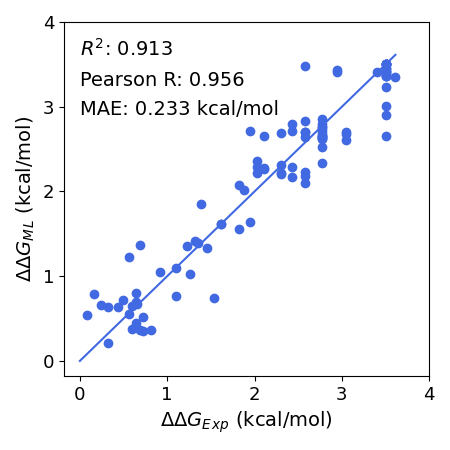

In [59]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='royalblue')

plt.text(0,3.6,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(val_Y,val_P),fontsize=14)

plt.plot([0,ddG.max()],[0,ddG.max()],c='royalblue')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()

OOS Test Set

In [60]:
oos_P = []
feature_importance = []
for _ in range(10):
    model.fit(train_val_desc[:,sel_index],train_val_target)
    oos_p = model.predict(oos_desc[:,sel_index])
    oos_P.append(oos_p)
oos_pred = np.mean(oos_P,axis=0)

r2 = r2_score(oos_target,oos_pred)
pearson_r,_ = pearsonr(oos_target,oos_pred)
mae = mean_absolute_error(oos_target,oos_pred)
print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.4217, R2: 0.7732, Pearson R: 0.9043


<IPython.core.display.Javascript object>


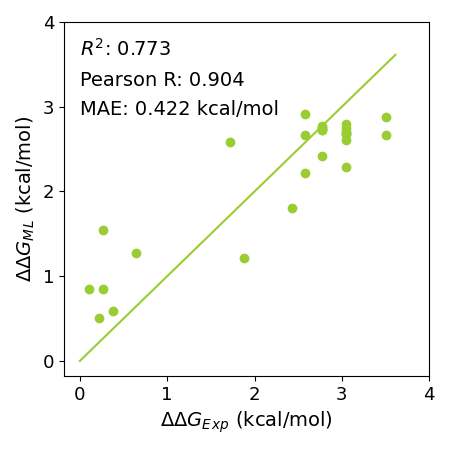

In [61]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(oos_target,oos_pred,c='yellowgreen')
plt.text(0,3.6,'$R^2$: %.3f'%r2_score(oos_target,oos_pred),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(oos_target,oos_pred)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(oos_target,oos_pred),fontsize=14)
plt.plot([0,ddG.max()],[0,ddG.max()],c='yellowgreen')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()

## Biaryl (GS) Olefin (TS) TDG (GS)

Hyperparameter Optimization

In [62]:
train_val_desc = b_gs_o_ts_t_gs[train_val_index]
train_val_target = ddG[train_val_index]
oos_desc = b_gs_o_ts_t_gs[test_index]
oos_target = ddG[test_index]

paras = {'n_estimators':[100,200,300,400,500,600],'max_depth': [None, 5, 10, 15, 20]}
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
model = ExtraTreesRegressor(n_jobs=-1,random_state=random_seed)
GS = GridSearchCV(model,paras,cv=cv,n_jobs=-1,scoring='r2')
GS.fit(train_val_desc,train_val_target)
best_param = GS.best_params_

Feature Selection

In [63]:
model = ExtraTreesRegressor(max_depth=best_param['max_depth'],n_estimators=best_param['n_estimators'],
                            n_jobs=-1,random_state=random_seed)

selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(train_val_desc,train_val_target)
sel_index = np.where(selector.support_==True)[0]

Cross-Validation

In [64]:
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(train_val_desc):
    train_x,val_x = train_val_desc[:,sel_index][train_idx],train_val_desc[:,sel_index][val_idx]
    train_y,val_y = train_val_target[train_idx],train_val_target[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.2296, R2: 0.9132, Pearson R: 0.9557


<IPython.core.display.Javascript object>


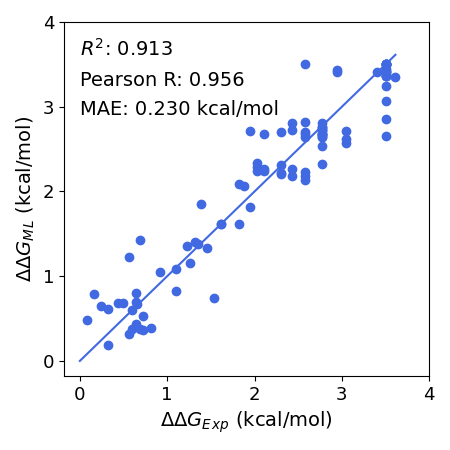

In [65]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='royalblue')

plt.text(0,3.6,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(val_Y,val_P),fontsize=14)

plt.plot([0,ddG.max()],[0,ddG.max()],c='royalblue')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()

OOS Test Set

In [66]:
oos_P = []
feature_importance = []
for _ in range(10):
    model.fit(train_val_desc[:,sel_index],train_val_target)
    oos_p = model.predict(oos_desc[:,sel_index])
    oos_P.append(oos_p)
oos_pred = np.mean(oos_P,axis=0)

r2 = r2_score(oos_target,oos_pred)
pearson_r,_ = pearsonr(oos_target,oos_pred)
mae = mean_absolute_error(oos_target,oos_pred)
print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.4370, R2: 0.7860, Pearson R: 0.9296


<IPython.core.display.Javascript object>


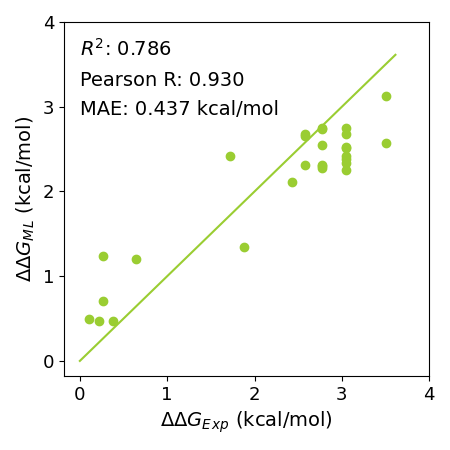

In [67]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(oos_target,oos_pred,c='yellowgreen')
plt.text(0,3.6,'$R^2$: %.3f'%r2_score(oos_target,oos_pred),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(oos_target,oos_pred)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(oos_target,oos_pred),fontsize=14)
plt.plot([0,ddG.max()],[0,ddG.max()],c='yellowgreen')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()

## Biaryl (GS) Olefin (GS) TDG (TS)

Hyperparameter Optimization

In [68]:
train_val_desc = b_gs_o_gs_t_ts[train_val_index]
train_val_target = ddG[train_val_index]
oos_desc = b_gs_o_gs_t_ts[test_index]
oos_target = ddG[test_index]

paras = {'n_estimators':[100,200,300,400,500,600],'max_depth': [None, 5, 10, 15, 20]}
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
model = ExtraTreesRegressor(n_jobs=-1,random_state=random_seed)
GS = GridSearchCV(model,paras,cv=cv,n_jobs=-1,scoring='r2')
GS.fit(train_val_desc,train_val_target)
best_param = GS.best_params_

Feature Selection

In [69]:
model = ExtraTreesRegressor(max_depth=best_param['max_depth'],n_estimators=best_param['n_estimators'],
                            n_jobs=-1,random_state=random_seed)

selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(train_val_desc,train_val_target)
sel_index = np.where(selector.support_==True)[0]

Cross-Validation

In [70]:
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(train_val_desc):
    train_x,val_x = train_val_desc[:,sel_index][train_idx],train_val_desc[:,sel_index][val_idx]
    train_y,val_y = train_val_target[train_idx],train_val_target[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.2219, R2: 0.9127, Pearson R: 0.9554


<IPython.core.display.Javascript object>


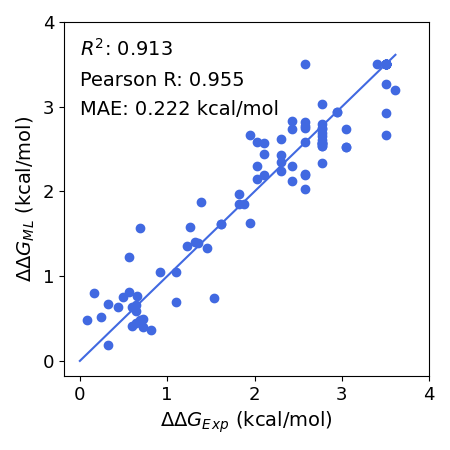

In [71]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='royalblue')

plt.text(0,3.6,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(val_Y,val_P),fontsize=14)

plt.plot([0,ddG.max()],[0,ddG.max()],c='royalblue')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()

OOS Test Set

In [72]:
oos_P = []
feature_importance = []
for _ in range(10):
    model.fit(train_val_desc[:,sel_index],train_val_target)
    oos_p = model.predict(oos_desc[:,sel_index])
    oos_P.append(oos_p)
oos_pred = np.mean(oos_P,axis=0)

r2 = r2_score(oos_target,oos_pred)
pearson_r,_ = pearsonr(oos_target,oos_pred)
mae = mean_absolute_error(oos_target,oos_pred)
print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.3937, R2: 0.8002, Pearson R: 0.9149


<IPython.core.display.Javascript object>


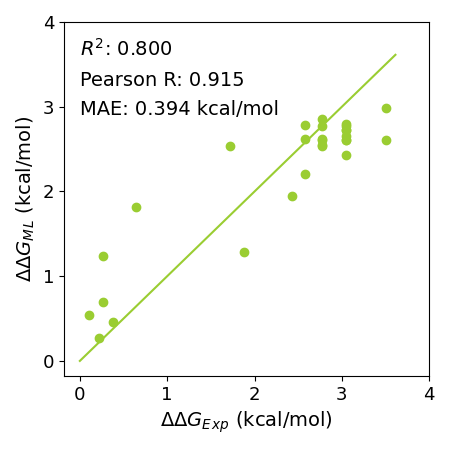

In [73]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(oos_target,oos_pred,c='yellowgreen')
plt.text(0,3.6,'$R^2$: %.3f'%r2_score(oos_target,oos_pred),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(oos_target,oos_pred)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(oos_target,oos_pred),fontsize=14)
plt.plot([0,ddG.max()],[0,ddG.max()],c='yellowgreen')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()

## Biaryl (GS) Olefin (GS) TDG (TS)

Hyperparameter Optimization

In [74]:
train_val_desc = b_ts_o_ts_t_ts[train_val_index]
train_val_target = ddG[train_val_index]
oos_desc = b_ts_o_ts_t_ts[test_index]
oos_target = ddG[test_index]

paras = {'n_estimators':[100,200,300,400,500,600],'max_depth': [None, 5, 10, 15, 20]}
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
model = ExtraTreesRegressor(n_jobs=-1,random_state=random_seed)
GS = GridSearchCV(model,paras,cv=cv,n_jobs=-1,scoring='r2')
GS.fit(train_val_desc,train_val_target)
best_param = GS.best_params_

Feature Selection

In [75]:
model = ExtraTreesRegressor(max_depth=best_param['max_depth'],n_estimators=best_param['n_estimators'],
                            n_jobs=-1,random_state=random_seed)

selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(train_val_desc,train_val_target)
sel_index = np.where(selector.support_==True)[0]

Cross-Validation

In [76]:
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(train_val_desc):
    train_x,val_x = train_val_desc[:,sel_index][train_idx],train_val_desc[:,sel_index][val_idx]
    train_y,val_y = train_val_target[train_idx],train_val_target[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.2359, R2: 0.9091, Pearson R: 0.9535


<IPython.core.display.Javascript object>


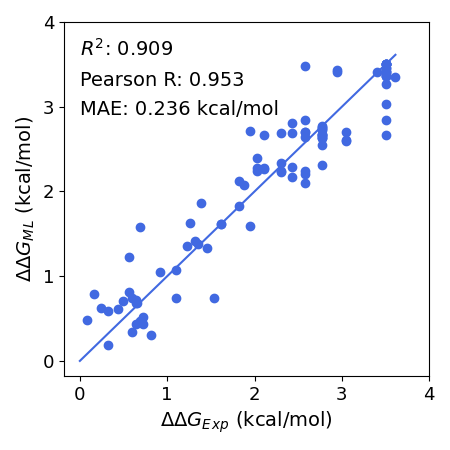

In [77]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='royalblue')

plt.text(0,3.6,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(val_Y,val_P),fontsize=14)

plt.plot([0,ddG.max()],[0,ddG.max()],c='royalblue')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()

OOS Test Set

In [78]:
oos_P = []
feature_importance = []
for _ in range(10):
    model.fit(train_val_desc[:,sel_index],train_val_target)
    oos_p = model.predict(oos_desc[:,sel_index])
    oos_P.append(oos_p)
oos_pred = np.mean(oos_P,axis=0)

r2 = r2_score(oos_target,oos_pred)
pearson_r,_ = pearsonr(oos_target,oos_pred)
mae = mean_absolute_error(oos_target,oos_pred)
print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.3738, R2: 0.8219, Pearson R: 0.9254


<IPython.core.display.Javascript object>


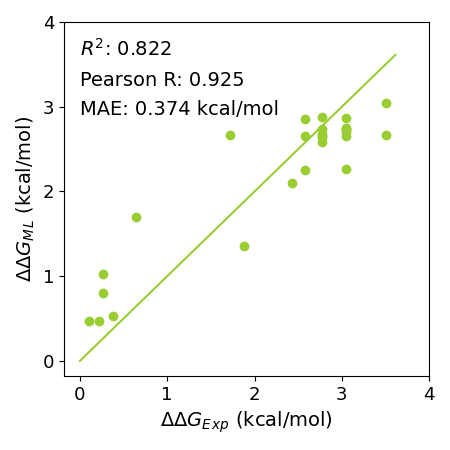

In [79]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(oos_target,oos_pred,c='yellowgreen')
plt.text(0,3.6,'$R^2$: %.3f'%r2_score(oos_target,oos_pred),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(oos_target,oos_pred)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(oos_target,oos_pred),fontsize=14)
plt.plot([0,ddG.max()],[0,ddG.max()],c='yellowgreen')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()